In [1]:
import os
import tensorflow as tf
import random
import zipfile
import numpy as np
import pandas as pd
import shutil
import IPython
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


from time import time
from glob import glob
from preprocessing import compute_linear_matrix, get_mfccs_training, get_mfcc, LABELS
from itertools import product
from functools import partial
from typing import Iterable, Any

from keras.callbacks import Callback,ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


TEAM_FOLDER = os.path.join('.', 'Final_Project_Model')
MODEL_NAME = 'model'
MODEL_PATH = os.path.join(TEAM_FOLDER, 'model', f'{MODEL_NAME}')

PLOT_FOLDER = os.path.join('.', 'PLOTS')

if not os.path.exists(TEAM_FOLDER):
    os.makedirs(TEAM_FOLDER)

if not os.path.exists(PLOT_FOLDER):
    os.makedirs(PLOT_FOLDER)


2023-07-06 21:52:14.880853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 21:52:14.939011: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 21:52:14.944649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 21:52:16.102982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA PREPARATION FOR SEP28K

### Creating no stutter files with 'NoStutteredWords', 'NaturalPause', 'Music', 'NoSpeech'  and count of 3458 
### and 
### Creating stutter files for  'Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection' to be detected as stuttering situation and count of 3324 

In [ ]:
# root_folder = './sep28_all_together/'  # Replace with the actual path to your root folder

# total_files = 0

# # Walk through the root folder and its subfolders
# for dirpath, dirnames, filenames in os.walk(root_folder):
#     total_files += len(filenames)

# print("Total number of files:", total_files)

# df_sep = pd.read_csv('SEP_28k_labels.csv')

# # Specify the source directory where your files are located
# source_directory = './sep28_all_together/'
# file_names = os.listdir(source_directory)
# random.shuffle(file_names)

# # Specify the destination directories for the split files
# destination_directory = './sep28_balanced_7'

# # Create the destination directories if they don't exist
# if not os.path.exists(destination_directory):
#     os.makedirs(destination_directory)


# count = 0

# def check_elements(lst, positions):
#     non_zero_count = 0

#     for i in range(len(lst)):
#         if i in positions:
#             if lst[i] != 0:
#                 non_zero_count += 1
#         elif lst[i] != 0:
#             return False
#     return  non_zero_count >= 1

# specific_positions = [8, 9, 10, 11]

# for filename in file_names:

#     path_parts = tf.strings.split(filename, '/')
#     path_end = path_parts[-1]
#     file_parts = tf.strings.split(path_end, '_')
#     show_name = file_parts[0].numpy().decode('utf-8')
#     pod_id = int(file_parts[-2])
#     clip_id = int(tf.strings.split(file_parts[-1], '.')[-2])
#     features = df_sep[(df_sep['Show'] == show_name) & (df_sep['EpId'] == pod_id) & (df_sep['ClipId'] == clip_id)].to_numpy()[0][5:]
    
#     if check_elements(features, specific_positions):
#         print(show_name,pod_id,clip_id, features,df_sep[(df_sep['Show'] == show_name) & (df_sep['EpId'] == pod_id) & (df_sep['ClipId'] == clip_id)][['NoStutteredWords','NaturalPause','Music','NoSpeech']])
#         count += 1
#         source_path = os.path.join(source_directory, filename)
#         destination_path = os.path.join(destination_directory, filename)
#         shutil.copy2(source_path, destination_path)

# print(count)

# # Specify the source directory where your files are located
# source_directory = './sep28_all_together/'
# file_names = os.listdir(source_directory)
# random.shuffle(file_names)

# # Specify the destination directories for the split files
# destination_directory = './sep28_balanced_7'

# # Create the destination directories if they don't exist
# if not os.path.exists(destination_directory):
#     os.makedirs(destination_directory)


# count = 0

# def check_elements(lst, positions):
#     non_zero_count = 0

#     for i in range(len(lst)):
#         if i in positions:
#             if lst[i] != 0:
#                 non_zero_count += 1
#         elif lst[i] != 0:
#             return False
#     return  non_zero_count >= 1

# specific_positions = [2, 3, 4, 5, 7]

# for filename in file_names:

#     path_parts = tf.strings.split(filename, '/')
#     path_end = path_parts[-1]
#     file_parts = tf.strings.split(path_end, '_')
#     show_name = file_parts[0].numpy().decode('utf-8')
#     pod_id = int(file_parts[-2])
#     clip_id = int(tf.strings.split(file_parts[-1], '.')[-2])
#     features = df_sep[(df_sep['Show'] == show_name) & (df_sep['EpId'] == pod_id) & (df_sep['ClipId'] == clip_id)].to_numpy()[0][5:]
    
#     if check_elements(features, specific_positions):
#         print(show_name,pod_id,clip_id)
#         print(features,df_sep[(df_sep['Show'] == show_name) & (df_sep['EpId'] == pod_id) & (df_sep['ClipId'] == clip_id)][['Prolongation', 'Block','SoundRep','WordRep','Interjection']])
#         count += 1

#         source_path = os.path.join(source_directory, filename)
#         destination_path = os.path.join(destination_directory, filename)
#         shutil.copy2(source_path, destination_path)
    
# print(count)

### Renaming files in sep28_balanced to nostutter (3458) and stutter files(3324):

In [ ]:
# # Specify the source directory where your files are located
# folder_path = './sep28_balanced_7/'

# for filename in os.listdir(folder_path):

#     path_parts = tf.strings.split(filename, '/')
#     path_end = path_parts[-1]
#     file_parts = tf.strings.split(path_end, '_')
#     show_name = file_parts[0].numpy().decode('utf-8')
#     pod_id = int(file_parts[-2])
#     clip_id = int(tf.strings.split(file_parts[-1], '.')[-2])
#     features = df_sep[(df_sep['Show'] == show_name) & (df_sep['EpId'] == pod_id) & (df_sep['ClipId'] == clip_id)].to_numpy()[0][5:]

    
#     if features[8] != 0:
#         print(features)
#         old_file_path = os.path.join(folder_path, filename)
#         new_filename = "nostutter_" + filename  # Replace "new_name_" with your desired naming convention
#         new_file_path = os.path.join(folder_path, new_filename)
#         os.rename(old_file_path, new_file_path)

#     else:
#         old_file_path = os.path.join(folder_path, filename)
#         new_filename = "stutter_" + filename  # Replace "new_name_" with your desired naming convention
#         new_file_path = os.path.join(folder_path, new_filename)
#         os.rename(old_file_path, new_file_path)

In [2]:
# Specify the directory where your .wav files are located
directory = './sep28_balanced_7/'

# Initialize a counter variable
count = 0
count1 = 0
# Iterate over the files in the directory
for filename in os.listdir(directory):
    if filename.startswith('nostutter'):
        count += 1
    if filename.startswith('stutter'):
        count1 += 1

print(f"Number of nostutter and stutter files: {count} , {count1} and tot {count+count1}")

Number of nostutter and stutter files: 3458 , 3324 and tot 6782


### Splitting into train, validation and test sets

In [ ]:
# # Specify the source directory where your files are located
# source_directory = './sep28_balanced_7'

# # Specify the destination directories for the split files
# destination_directory_1 = './train_sep28_7'
# destination_directory_2 = './val_sep28_7'
# destination_directory_3 = './test_sep28_7'

# # Create the destination directories if they don't exist
# for directory in [destination_directory_1, destination_directory_2, destination_directory_3]:
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # Shuffle the files in the source directory
# files = os.listdir(source_directory)
# random.shuffle(files)

# # Define the sizes for each split
# split_sizes = [0.8, 0.1, 0.1]

# # Calculate the number of files for each split
# total_files = len(files)
# split_counts = [int(size * total_files) for size in split_sizes]

# # Split the files into different lists based on the split counts
# file_splits = [files[:split_counts[0]], files[split_counts[0]:split_counts[0] + split_counts[1]], files[-split_counts[2]:]]

# count = 0
# # Move the files to the destination directories
# for i, file_split in enumerate(file_splits):
#     if i == 0:
#         destination_directory = destination_directory_1
#     elif i == 1:
#         destination_directory = destination_directory_2
#     else:
#         destination_directory = destination_directory_3

#     for filename in file_split:
#         source_path = os.path.join(source_directory, filename)
#         destination_path = os.path.join(destination_directory, filename)
#         shutil.copy2(source_path, destination_path)
    
#         count += 1

# print(count)

### Information about splited sets

In [2]:
# Specify the directory where your .wav files are located
directory1 = './train_sep28_7'
directory2 = './val_sep28_7'
directory3 = './test_sep28_7'

# Initialize a counter variable
count_train = 0
count_val = 0
count_test = 0

count_train_tot = 0
count_val_tot = 0
count_test_tot = 0

# Iterate over the files in the directory
for filename in os.listdir(directory1):
    if filename.startswith('nostutter'):
        count_train += 1
    if filename.endswith('.wav'):
        count_train_tot += 1
    if not filename.endswith('.wav'):
        print('error')
    if not filename.startswith('nostutter') and not filename.startswith('stutter'):
        print(filename)

# Iterate over the files in the directory
for filename in os.listdir(directory2):
    if filename.startswith('nostutter'):
        count_val += 1
    if filename.endswith('.wav'):
        count_val_tot += 1
    if not filename.endswith('.wav'):
        print('error')
    if not filename.startswith('nostutter') and not filename.startswith('stutter'):
        print(filename)

# Iterate over the files in the directory
for filename in os.listdir(directory3):
    if filename.startswith('nostutter'):
        count_test += 1    
    if filename.endswith('.wav'):
        count_test_tot += 1
    if not filename.endswith('.wav'):
        print('error')
    if not filename.startswith('nostutter') and not filename.startswith('stutter'):
        print(filename)

print('**********Sep28 dataset**********')
print(f"Number of nostutter files in the train folder: {count_train} and tot is {count_train_tot}")
print(f"Number of nostutter files in the val folder: {count_val} and tot is {count_val_tot}")
print(f"Number of nostutter files in the test folder: {count_test} and tot is {count_test_tot}")

**********Sep28 dataset**********
Number of nostutter files in the train folder: 2771 and tot is 5425
Number of nostutter files in the val folder: 344 and tot is 678
Number of nostutter files in the test folder: 343 and tot is 678


# AUIDO PRE-PROCESSING

In [3]:
PREPROCESSING_ARGS = {
        'downsampling_rate': 16000,
        'frame_length_in_s': 0.032,
        'frame_step_in_s': 0.032,
        'num_mel_bins': 40,
        'num_coefficients': 20,
        'lower_frequency': 20,
        'upper_frequency': 8000}

Label: tf.Tensor(b'nostutter', shape=(), dtype=string)
Label: nostutter
Audio shape: (48000, 1)
Sampling rate: 16000


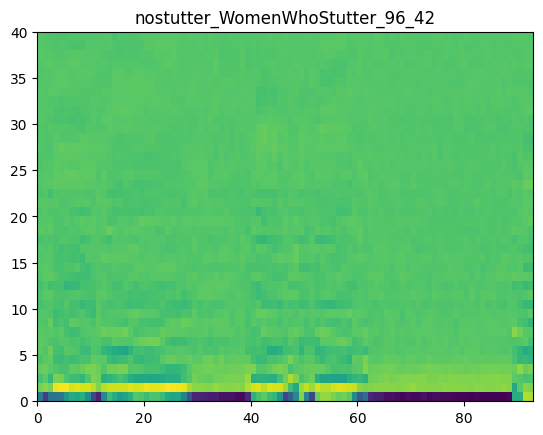

Audio shape: (48000,)
tf.Tensor((-9.050752-0.00052177906j), shape=(), dtype=complex64)
FFT shape: (24001,)


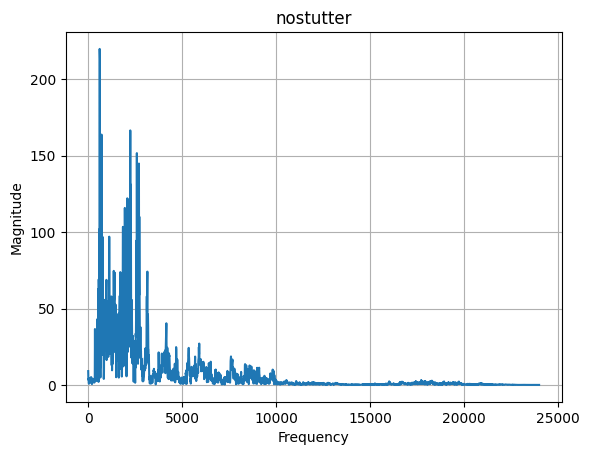

In [4]:
filename_nostutter = './sep28_balanced_7/nostutter_WomenWhoStutter_96_42.wav'

#Convert audio to MFCCS
nostutter_mfccs, _ = get_mfccs_training(filename_nostutter, **PREPROCESSING_ARGS)
#Transpose for visualization
nostutter_vis = tf.transpose(nostutter_mfccs)

audio_binary = tf.io.read_file(filename_nostutter)
audio, sampling_rate = tf.audio.decode_wav(audio_binary)

path_parts = tf.strings.split(filename_nostutter, '/')
path_end = path_parts[-1]
file_parts = tf.strings.split(path_end, '_')
label = file_parts[0]

print('Label:', label) 
print('Label:', label.numpy().decode())
print('Audio shape:', audio.shape)
print('Sampling rate:', sampling_rate.numpy())

plt.figure()
plt.pcolormesh(nostutter_vis.numpy())
plt.title("nostutter_WomenWhoStutter_96_42")
plt.savefig(os.path.join(PLOT_FOLDER, "nostutter_WomenWhoStutter_96_42.png"))
plt.show()

audio = tf.squeeze(audio)
print('Audio shape:', audio.shape)

audio_fft = tf.signal.rfft(audio)
print(audio_fft[0])

audio_fft_magnitude = tf.abs(audio_fft)

print('FFT shape:', audio_fft.shape)

plot = {
    'Frequency': np.arange(0, audio_fft_magnitude.shape[0])[0::10],
    'Magnitude': audio_fft_magnitude.numpy().squeeze()[0::10]
}
plot_df = pd.DataFrame(plot)

plt.plot(plot['Frequency'], plot['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title(f'{label.numpy().decode()}')
plt.grid()
plt.savefig(os.path.join(PLOT_FOLDER, f'{label.numpy().decode()}_DFT.png')) 

IPython.display.Audio(filename=filename_nostutter, rate=sampling_rate)

Label: tf.Tensor(b'stutter', shape=(), dtype=string)
Label: stutter
Audio shape: (48000, 1)
Sampling rate: 16000


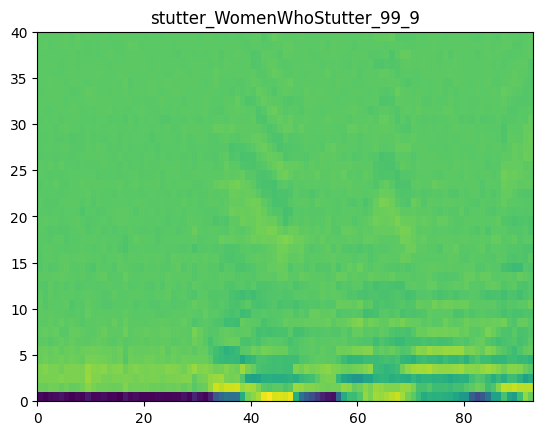

Audio shape: (48000,)
tf.Tensor((-3.9591966-0.00047016144j), shape=(), dtype=complex64)
FFT shape: (24001,)


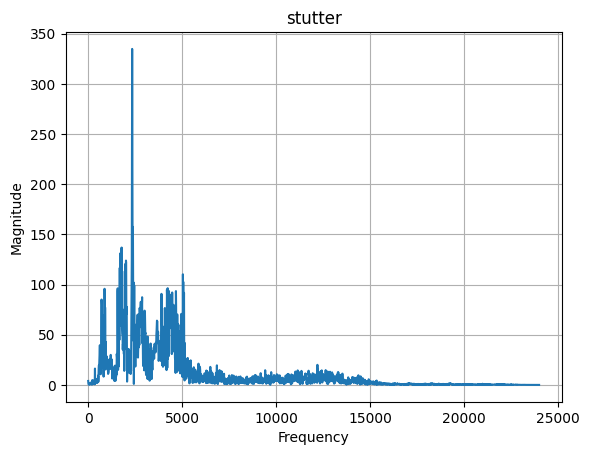

In [5]:
filename_stutter = './sep28_balanced_7/stutter_WomenWhoStutter_99_9.wav'
#Convert audio to MFCCS
stutter_mfccs, _ = get_mfccs_training(filename_stutter, **PREPROCESSING_ARGS)
#Transpose for visualization
stutter_vis = tf.transpose(stutter_mfccs)

audio_binary = tf.io.read_file(filename_stutter)
audio, sampling_rate = tf.audio.decode_wav(audio_binary) 

path_parts = tf.strings.split(filename_stutter, '/')
path_end = path_parts[-1]
file_parts = tf.strings.split(path_end, '_')
label = file_parts[0]

print('Label:', label) 
print('Label:', label.numpy().decode())
print('Audio shape:', audio.shape)
print('Sampling rate:', sampling_rate.numpy())

plt.figure()
plt.pcolormesh(stutter_vis.numpy())
plt.title("stutter_WomenWhoStutter_99_9")
plt.savefig(os.path.join(PLOT_FOLDER, "stutter_WomenWhoStutter_99_9.png"))
plt.show()

audio = tf.squeeze(audio)
print('Audio shape:', audio.shape)

audio_fft = tf.signal.rfft(audio)
print(audio_fft[0])

audio_fft_magnitude = tf.abs(audio_fft)

print('FFT shape:', audio_fft.shape)

plot = {
    'Frequency': np.arange(0, audio_fft_magnitude.shape[0])[0::10],
    'Magnitude': audio_fft_magnitude.numpy().squeeze()[0::10]
}
plot_df = pd.DataFrame(plot)

plt.plot(plot['Frequency'], plot['Magnitude'])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title(f'{label.numpy().decode()}')
plt.grid()
plt.savefig(os.path.join(PLOT_FOLDER, f'{label.numpy().decode()}_DFT.png')) 

IPython.display.Audio(filename=filename_stutter, rate=sampling_rate)

# TRAIN

In [2]:
train_ds_pure = tf.data.Dataset.list_files(['train_sep28_7/*'])
val_ds_pure = tf.data.Dataset.list_files(['val_sep28_7/*'])

# Shuffle the dataset
train_ds_shuffled = train_ds_pure.shuffle(buffer_size=len(train_ds_pure), seed=seed)
val_ds_shuffled = val_ds_pure.shuffle(buffer_size=len(val_ds_pure), seed=seed)

In [3]:
# true_labels = []
# directory = './train_sep28_7'
# for filename in os.listdir(directory):
#     label = tf.strings.split(tf.strings.split(filename, '/')[-1], '_')[0]
#     true_labels.append(label.numpy())


# from sklearn.utils import class_weight

# # Assuming you have the true labels in an array called 'true_labels'
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(true_labels), y=true_labels)


# class_weights_dict = dict(enumerate(class_weights))
# class_weights_dict
class_weights_dict = {0: 0.9788884879105016, 1: 1.0220422004521477}

In [4]:
def preprocess(filename):
    signal, label = get_frozen_spectrogram(filename)
    signal.set_shape(SHAPE)
    signal = tf.expand_dims(signal, -1)
    signal = tf.image.resize(signal, [32,32])
    label_id = tf.argmax(label == LABELS)

    return signal, label_id


def get_model(alpha, model_filter, input_shape):
    '''Returns the model'''
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[2, 2], use_bias=False, padding='valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(filters=int(model_filter * alpha), kernel_size=[3, 3], strides=[1, 1], use_bias=False, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=len(LABELS)),
        tf.keras.layers.Softmax()
    ])


def save_model(model, path):
    '''Saves the model'''
    if not os.path.exists(path):
        os.makedirs(path)
    model.save(path)

def convert_model(model, model_path, tflite_path, model_name):
    '''Converts the saved model into tflite model and saves it (also zip version)'''
    converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
    tflite_model = converter.convert()

    if not os.path.exists(tflite_path):
        os.makedirs(tflite_path)
    tflite_model_path = os.path.join(tflite_path, f'{model_name}.tflite')

    with open(tflite_model_path, 'wb') as fp:
        fp.write(tflite_model)

    with zipfile.ZipFile(f'{tflite_model_path}.zip', 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(tflite_model_path, 'model.tflite')
    
    sizes = {
        'tflite_model_size' : os.path.getsize(f'{tflite_model_path}') / 1024.0,
        'tflite_zip_model_size' : os.path.getsize(f'{tflite_model_path}.zip') / 1024.0
    }

    return tflite_model_path, sizes

def print_results(name, parameters, model_accuracies, sizes):
    '''saves results in a csv'''
    output_dict = {
                    'model_name': name,
                    **parameters,
                    **model_accuracies,
                    **sizes
            }
    print(output_dict.values())

In [5]:
def training(downsampling_rate, frame_length_in_s, frame_step_in_s, num_mel_bins, num_coefficients, lower_frequency,
 upper_frequency, batch_size, initial_learning_rate, end_learning_rate, epochs, model_filter, alpha, initial_sparsity,
 final_sparsity):

    # frame_step_in_s = frame_length_in_s
    # upper_frequency = downsampling_rate/2
    # num_coefficients = num_mel_bins
    
    # ******************* Parameter definition ***********************************************************
    PREPROCESSING_ARGS = {
        'downsampling_rate': downsampling_rate,
        'frame_length_in_s': frame_length_in_s,
        'frame_step_in_s': frame_step_in_s, 
        'num_mel_bins': num_mel_bins,
        'num_coefficients': num_coefficients,
        'lower_frequency': lower_frequency,
        'upper_frequency': upper_frequency,
    }
    
    # ******************* Preprocessing ***********************************************************
    global SHAPE, get_frozen_spectrogram

    get_frozen_spectrogram = partial(get_mfccs_training, **PREPROCESSING_ARGS)

    for mfcc, label in train_ds_pure.map(get_frozen_spectrogram).take(1):
        SHAPE = mfcc[:num_coefficients].shape
        print(label)


    train_ds = train_ds_shuffled.map(preprocess).batch(batch_size).cache()
    val_ds = val_ds_shuffled.map(preprocess).batch(batch_size)

    #get shape for model input
    for example_batch, example_labels in train_ds.take(1):
        input_shape = example_batch.shape[1:]
    

    # ******************* Model And Training *******************************************************
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
    metrics=[tf.metrics.SparseCategoricalAccuracy()]
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
    
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=initial_learning_rate,
        end_learning_rate=end_learning_rate,
        decay_steps=len(train_ds) * epochs,
    )

    optimizer = tf.optimizers.Adam(learning_rate=linear_decay)

    begin_step = int(len(train_ds_pure) * epochs * 0.2)
    end_step = int(len(train_ds_pure) * epochs)

    # Pruning
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity= initial_sparsity,
            final_sparsity= final_sparsity,
            begin_step=begin_step,
            end_step=end_step
        )
    }


    model = tfmot.sparsity.keras.prune_low_magnitude(get_model(alpha, model_filter, input_shape), **pruning_params)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks, class_weight=class_weights_dict)


    # ******************* Results ***************************************************************
    _, training_accuracy = model.evaluate(train_ds)
    _, validation_accuracy = model.evaluate(val_ds)

    accuracies = {
        'training_accuracy_tf': training_accuracy*100,
        'validation_accuracy_tf': validation_accuracy*100,
    }
    
    fig = plt.figure()
    plt.plot(history.history['loss'], c='b')
    plt.plot(history.history['sparse_categorical_accuracy'], c='c')
    plt.title(f"Training Loss and Accuracy")
    plt.legend(['train_loss', 'train_accuracy'])
    plt.xlabel('Epoch')
    plt.savefig(os.path.join(PLOT_FOLDER, f"{MODEL_NAME}.png"))

    return model, accuracies 

In [6]:
ARGUMENTS = {
        'downsampling_rate': 16000,
        'frame_length_in_s': 0.032,
        'frame_step_in_s': 0.032,
        'num_mel_bins': 40,
        'num_coefficients': 20,
        'lower_frequency': 20,
        'upper_frequency': 8000,
        'batch_size': 20,
        'initial_learning_rate': 0.01,
        'end_learning_rate': 1.e-5,
        'epochs': 20,
        'model_filter': 128,
        'alpha': 0.2,
        'initial_sparsity': 0.2,
        'final_sparsity': 0.6
    }

2023-07-06 21:52:46.251066: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


2023-07-06 21:52:46.843100: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:46.843382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:46.846837: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:46.846933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:46.847434: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:

tf.Tensor(b'stutter', shape=(), dtype=string)


2023-07-06 21:52:48.121507: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:48.121564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:48.124268: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:48.124298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:48.124704: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:

2023-07-06 21:52:48.818744: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:48.818976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:48.822371: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:48.822458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library
	 [[{{node stft/frame/gcd/while}}]]
2023-07-06 21:52:48.822956: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:375 : INTERNAL: No function library
2023-07-06 21:52:

Epoch 1/20
270/272 [============================>.] - ETA: 0s - loss: 0.6947 - sparse_categorical_accuracy: 0.5252

2023-07-06 21:53:01.731061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [678]
	 [[{{node Placeholder/_0}}]]
2023-07-06 21:53:01.731439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [678]
	 [[{{node Placeholder/_0}}]]


272/272 [==============================] - 13s 29ms/step - loss: 0.6948 - sparse_categorical_accuracy: 0.5250 - val_loss: 0.6815 - val_sparse_categorical_accuracy: 0.5708
Epoch 2/20
272/272 [==============================] - 4s 14ms/step - loss: 0.6717 - sparse_categorical_accuracy: 0.5840 - val_loss: 0.7444 - val_sparse_categorical_accuracy: 0.5206
Epoch 3/20
272/272 [==============================] - 4s 15ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.6308 - val_loss: 1.1214 - val_sparse_categorical_accuracy: 0.5103
Epoch 4/20
272/272 [==============================] - 4s 15ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.6518 - val_loss: 1.1527 - val_sparse_categorical_accuracy: 0.5133
Epoch 5/20
272/272 [==============================] - 4s 15ms/step - loss: 0.6073 - sparse_categorical_accuracy: 0.6717 - val_loss: 1.0946 - val_sparse_categorical_accuracy: 0.5147
Epoch 6/20
272/272 [==============================] - 4s 14ms/step - loss: 0.5960 - sparse_categorical_ac

2023-07-06 21:54:20.126903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5425]
	 [[{{node Placeholder/_0}}]]
2023-07-06 21:54:20.127326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5425]
	 [[{{node Placeholder/_0}}]]


34/34 [==============================] - 1s 7ms/step - loss: 0.5799 - sparse_categorical_accuracy: 0.7212


INFO:tensorflow:Assets written to: ./Final_Project_Model/model/model/assets


INFO:tensorflow:Assets written to: ./Final_Project_Model/model/model/assets
2023-07-06 21:54:34.085311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-06 21:54:34.085374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-06 21:54:34.086283: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ./Final_Project_Model/model/model
2023-07-06 21:54:34.106836: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-06 21:54:34.106873: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ./Final_Project_Model/model/model
2023-07-06 21:54:34.145945: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-06 21:54:34.152831: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-06 21:54:34.289330: I tensorflow/

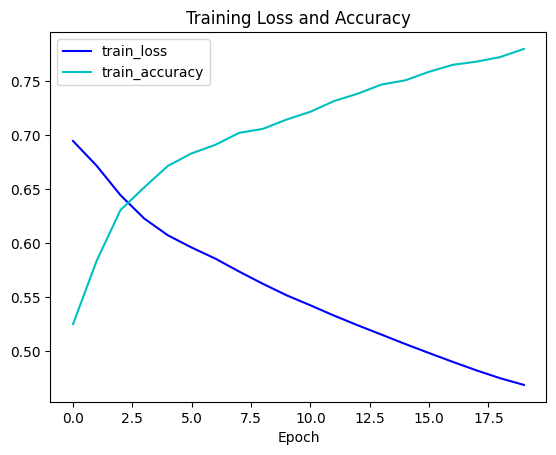

In [7]:
model, accuracies = training(**ARGUMENTS)
save_model(model, MODEL_PATH)

TFLITE_PATH = os.path.join(TEAM_FOLDER, 'tflite_model')
TFLITE_NAME, sizes = convert_model(model, MODEL_PATH, TFLITE_PATH, MODEL_NAME)

In [8]:
results = print_results(MODEL_NAME, ARGUMENTS, accuracies, sizes)
display(results)

dict_values(['model', 16000, 0.032, 0.032, 40, 20, 20, 8000, 20, 0.01, 1e-05, 20, 128, 0.2, 0.2, 0.6, 78.19355130195618, 72.1238911151886, 54.265625, 45.6220703125])


None

# Test

In [9]:
tflite_path = os.path.join(TFLITE_PATH, f'{MODEL_NAME}.tflite')
interpreter = tf.lite.Interpreter(model_path= tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Number of inputs:", len(input_details))
print("Number of outputs:", len(output_details))
print("Input name:", input_details[0]['name'])
print("Input shape:", input_details[0]['shape'])
print("Output name:", output_details[0]['name'])
print("Output shape:", output_details[0]['shape'])

Number of inputs: 1
Number of outputs: 1
Input name: serving_default_input_1:0
Input shape: [ 1 32 32  1]
Output name: StatefulPartitionedCall:0
Output shape: [1 2]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
test_ds_pure = tf.data.Dataset.list_files(['test_sep28_7/*'])
test_ds_shuffled = test_ds_pure.shuffle(buffer_size=len(test_ds_pure), seed=seed)

In [11]:
PREPROCESSING_ARGS = {
        'downsampling_rate': 16000,
        'frame_length_in_s': 0.032,
        'frame_step_in_s': 0.032,
        'num_mel_bins': 40,
        'num_coefficients': 20,
        'lower_frequency': 20,
        'upper_frequency': 8000}

avg_preprocessing_latency = 0
avg_model_latency = 0
latencies = []
accuracy = 0.0
predictions= []
labels = []
incorrect = []

sampling_rate_float32 = tf.cast(PREPROCESSING_ARGS['downsampling_rate'], tf.float32)
frame_length = int(sampling_rate_float32 * PREPROCESSING_ARGS['frame_length_in_s'])
frame_step = int(sampling_rate_float32 * PREPROCESSING_ARGS['frame_step_in_s'])

weigth_matrix = compute_linear_matrix(
    PREPROCESSING_ARGS['downsampling_rate'], 
    PREPROCESSING_ARGS['num_mel_bins'],
    PREPROCESSING_ARGS['lower_frequency'],
    PREPROCESSING_ARGS['upper_frequency'],
    frame_length
)

for filename in test_ds_shuffled:
    
    audio_binary = tf.io.read_file(filename)

    # NEED ONLY FOR TESTING
    true_label = tf.strings.split(tf.strings.split(filename, '/')[-1], '_')[0]
    true_label = true_label.numpy().decode()
    labels.append(LABELS.index(true_label))

    # PRE-PROCESSING (AUDIO -> MFCCS)
    start_preprocess = time()

    mfccs = get_mfcc(audio_binary, 
                    PREPROCESSING_ARGS['downsampling_rate'],
                    frame_length,
                    frame_step,
                    weigth_matrix)
    
    mfccs = tf.expand_dims(mfccs, 0)  # batch axis
    mfccs = tf.expand_dims(mfccs, -1)  # channel axis   
    mfccs = tf.image.resize(mfccs, [32,32])

    end_preprocess = time()

    #INFERENCE WITH TFLITE MODEL 

    interpreter.set_tensor(input_details[0]['index'], mfccs)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    end_inference = time()

    top_index = np.argmax(output[0])
    predicted_label = LABELS[top_index]

    predictions.append(top_index)

    if true_label == predicted_label:
        accuracy += 1
    else:
        incorrect.append(filename)

    avg_preprocessing_latency += (end_preprocess - start_preprocess)
    avg_model_latency += (end_inference - end_preprocess)
    latencies.append(end_inference - start_preprocess)

#COMPUTE STATISTICS FOR TEST SET
accuracy /= len(test_ds_shuffled)
avg_preprocessing_latency /= len(test_ds_shuffled)
avg_model_latency /= len(test_ds_shuffled)
median_total_latency = np.median(latencies)

print(f'Preprocessing Latency: {1000 * avg_preprocessing_latency:.1f}ms')
print(f'Model Latency: {1000 * avg_model_latency:.1f}ms')
print(f'Total Latency: {1000 * median_total_latency:.1f}ms')
print(f"Test accuracy : {accuracy*100:.3f}%")

2023-07-06 21:55:20.247262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [678]
	 [[{{node Placeholder/_0}}]]
2023-07-06 21:55:20.247714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [678]
	 [[{{node Placeholder/_0}}]]


Preprocessing Latency: 15.5ms
Model Latency: 0.4ms
Total Latency: 16.0ms
Test accuracy : 74.336%


[[264  79]
 [ 95 240]]
tn, fp, fn, tp: 264 79 95 240
F1_score for Sep28k: 73.394%


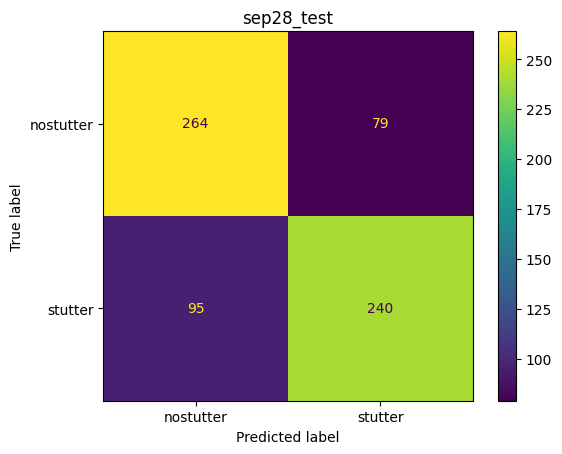

In [12]:
cm =confusion_matrix(labels, predictions)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
print('tn, fp, fn, tp:',tn, fp, fn, tp )
f1_cm = tp/(tp+(fn+fp)/2)
print(f'F1_score for Sep28k: {f1_cm*100:.3f}%')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot()
plt.title('sep28_test')
plt.savefig(os.path.join(PLOT_FOLDER, "Confusion_Matrix.png"))
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5c74a7a1-d505-4b2b-a4fa-efea0c0f20da' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>